In [70]:
!pip install hmmlearn

In [113]:
import numpy as np
from hmmlearn.hmm import CategoricalHMM
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from google.colab import drive
import os
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [72]:
# Mount Google Drive
drive.mount('/content/drive')
# the folder phases_classes contains 6 folders which contain the phases, classified by attack type
#i upload each group of files belonging to the same attack individually, the folder phases classes will be provided in github
assetdisc_path = '/content/drive/MyDrive/phases_classes/asset_discovery'
dataexf_path = '/content/drive/MyDrive/phases_classes/data_exfiltration'
networkdisc_path = '/content/drive/MyDrive/phases_classes/remote_net'
persistence_path = '/content/drive/MyDrive/phases_classes/persistence'
privilegeesc_path = '/content/drive/MyDrive/phases_classes/privilege_escalation'
reconnaissance_path = '/content/drive/MyDrive/phases_classes/discovery'
# Function to load system calls from a folder
def load_system_calls_from_folder(folder_path):
    sequences = []  # This will store the array of arrays

    # Traverse through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Read each file's content
        with open(file_path, 'r') as file:
            # Each line in the file represents one system call
            system_calls = [line.strip() for line in file if line.strip()]
            # Append the system calls from this file to the main list
            sequences.append(system_calls)

    return sequences
# Load sequences from files in the Google Drive folder
assetdisc_sequences = load_system_calls_from_folder(assetdisc_path)
dataexf_sequences = load_system_calls_from_folder(dataexf_path)
networkdisc_sequences = load_system_calls_from_folder(networkdisc_path)
persistence_sequences = load_system_calls_from_folder(persistence_path)
privilegeesc_sequences = load_system_calls_from_folder(privilegeesc_path)
reconnaissance_sequences = load_system_calls_from_folder(reconnaissance_path)

print(len(assetdisc_sequences))
print(len(dataexf_sequences))
print(len(networkdisc_sequences))
print(len(persistence_sequences))
print(len(privilegeesc_sequences))
print(len(reconnaissance_sequences))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
16
14
19
12
14
39


In [73]:
print(assetdisc_sequences[0])

['ruby2.3 → exec → ruby2.3', 'ruby2.3 → exec → find', 'ruby2.3 → exec → bash', 'bash → exec → bash', 'bash → exec → bash', 'bash → exec → aDZSrhin', 'aDZSrhin → exec → bash', 'bash → exec → find']


In [74]:
states = ["Bash execute process", "Execute process", "Server daemon operation", "Init server daemon", "System operation",
         "Generic process read write","Generic process operation", "Netapp operation", "Bash operation",
         "File operation","System information","Library state","Process upload download",
         "Netapp upload download","Daemon upload download","Server download","Server upload"]

In [75]:
#generalize IPs and ports in each observation
def generalize_observation(observation):
    observation = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}:\d+\b', 'IP_ADDRESS:PORT', observation)
    observation = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', 'IP_ADDRESS', observation)
    return observation
#convert observations to unique identifiers
def convert_to_identifiers(sequences):
    # Dictionary to assign a unique ID to each unique observation
    observation_to_id = {}
    next_id = 0
    processed_sequences = []
    for sequence in sequences:
        processed_sequence = []
        for observation in sequence:
            generalized_observation = generalize_observation(observation)
            # Assign a new ID if this observation hasn't been seen before
            if generalized_observation not in observation_to_id:
                observation_to_id[generalized_observation] = next_id
                next_id += 1
            # Append the ID of the observation
            processed_sequence.append(observation_to_id[generalized_observation])
        processed_sequences.append(processed_sequence)
    return processed_sequences, observation_to_id
#running this for each type alone might cause 1 observation to be mapped to more than 1 ID if the observation appears in more than 1 type
all_sequences = (
    assetdisc_sequences +
    dataexf_sequences +
    networkdisc_sequences +
    persistence_sequences +
    privilegeesc_sequences +
    reconnaissance_sequences
)
processed_sequences, observation_to_id = convert_to_identifiers(all_sequences)
print(len(observation_to_id))
print("\nObservation to ID Mapping:")
for i, (obs, idx) in enumerate(observation_to_id.items()):
    if i >= 5:
        break
    print(f"{obs}: {idx}")

5681

Observation to ID Mapping:
ruby2.3 → exec → ruby2.3: 0
ruby2.3 → exec → find: 1
ruby2.3 → exec → bash: 2
bash → exec → bash: 3
bash → exec → aDZSrhin: 4


In [76]:
print(len(processed_sequences))

114


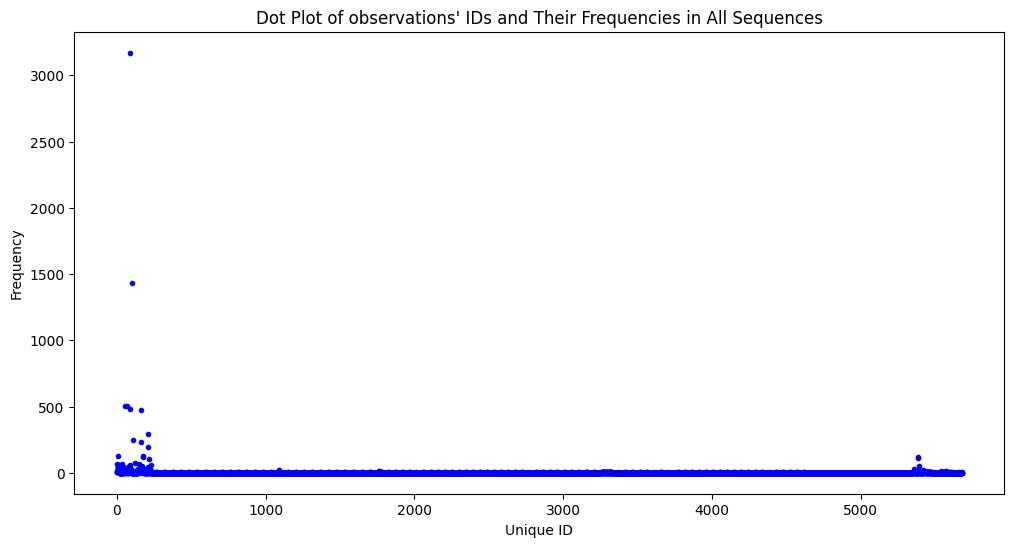

In [77]:
# Flatten processed_sequences into a single list of IDs
all_ids = [id for sequence in processed_sequences for id in sequence]
# Count occurrences of each ID
id_counts = Counter(all_ids)
ids, frequencies = zip(*id_counts.items())
plt.figure(figsize=(12, 6))
plt.plot(ids, frequencies, 'bo', markersize=3)
plt.xlabel("Unique ID")
plt.ylabel("Frequency")
plt.title("Dot Plot of observations' IDs and Their Frequencies in All Sequences")
plt.show()

Top 20 Most Common IDs and Their Frequencies:
ID: 91, Frequency: 3170
ID: 101, Frequency: 1429
ID: 58, Frequency: 501
ID: 68, Frequency: 501
ID: 90, Frequency: 480
ID: 165, Frequency: 474
ID: 208, Frequency: 292
ID: 112, Frequency: 245
ID: 166, Frequency: 235
ID: 209, Frequency: 196
ID: 178, Frequency: 126
ID: 12, Frequency: 124
ID: 179, Frequency: 119
ID: 5383, Frequency: 117
ID: 5384, Frequency: 111
ID: 220, Frequency: 105
ID: 122, Frequency: 74
ID: 150, Frequency: 68
ID: 3, Frequency: 67
ID: 39, Frequency: 67


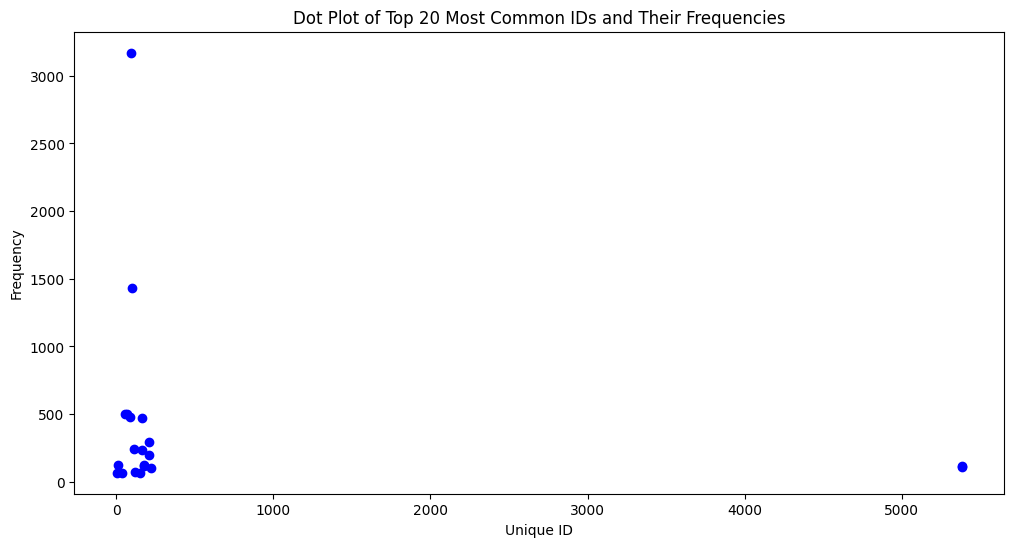

In [78]:
# Get the N most common IDs and their frequencies
N = 20
most_common_ids = id_counts.most_common(N)
print(f"Top {N} Most Common IDs and Their Frequencies:")
for id, freq in most_common_ids:
    print(f"ID: {id}, Frequency: {freq}")
ids, frequencies = zip(*most_common_ids)
plt.figure(figsize=(12, 6))
plt.plot(ids, frequencies, 'bo', markersize=6)  # 'bo' for blue dots
plt.xlabel("Unique ID")
plt.ylabel("Frequency")
plt.title(f"Dot Plot of Top {N} Most Common IDs and Their Frequencies")
plt.show()

In [79]:
print(len(all_ids))

21633


In [80]:
most_common_ids = [
    91, 100, 58, 68, 109, 165, 208, 90, 166, 209,
    184, 12, 185, 5353, 5354, 220, 119, 150, 8, 43
]

for i, (obs, idx) in enumerate(observation_to_id.items()):
    if i in most_common_ids:
      print(f"{obs}: {idx}")


ircd → exec → bash: 8
perl → exec → bash: 12
JdbUR5by → exec → bash: 43
nc → read → /var/www/html/drupal/sites/default/files/styles/large/public/field/image/5_of_hearts.png: 58
nc → read → /var/www/html/drupal/sites/default/files/field/image/5_of_hearts.png: 68
nc → read → /opt/readme_app/public/images/10_of_spades.png: 90
nc → write → IP_ADDRESS:PORT->IP_ADDRESS:PORT: 91
nc → connect → 0->ffff8800785cc700 /var/run/nscd/socket: 100
bash → close → /lost+found/3_of_hearts.png: 109
nc → connect → 0->ffff88007b137800 /var/run/nscd/socket: 119
nmbd → sendto → IP_ADDRESS:PORT->IP_ADDRESS:PORT: 150
apache2 → read → IP_ADDRESS:PORT->IP_ADDRESS:PORT: 165
apache2 → writev → IP_ADDRESS:PORT->IP_ADDRESS:PORT: 166
sshd → shutdown → IP_ADDRESS:PORT->IP_ADDRESS:PORT: 184
ircd → accept → IP_ADDRESS:PORT->IP_ADDRESS:PORT: 185
nodejs → write → IP_ADDRESS:PORT->IP_ADDRESS:PORT: 208
nodejs → read → IP_ADDRESS:PORT->IP_ADDRESS:PORT: 209
bash → exec → uname: 220
bash → exec → lXqzVpYN: 5353
lXqzVpYN → conne

In [81]:
print(processed_sequences[:10])

[[0, 1, 2, 3, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12, 13, 14, 6], [0, 1, 15, 6], [16, 17, 17, 18, 6, 6, 15, 6], [0, 1, 1], [19, 16, 17, 17, 18, 6, 20, 21, 22, 23, 24, 25, 26, 6, 20, 21, 22, 23, 27, 27, 28, 29, 30, 31, 32, 33, 15, 6, 34, 35, 36], [37, 38, 39, 9, 10, 11, 12, 40, 41, 6], [37, 38, 39, 9, 10, 11, 11, 12, 42, 43, 6], [16, 17, 17, 18, 6, 44, 45, 6], [46, 0, 47, 48, 49, 50, 51]]


In [82]:
X = np.concatenate(processed_sequences)
lengths = [len(seq) for seq in processed_sequences]
print(len(X))
print(X[:5])
print(len(lengths))
print(lengths[:5])

21633
[0 1 2 3 3]
114
[8, 9, 4, 8, 3]


In [83]:
def translation(arr1):
  output=[]
  arr=np.concatenate(arr1)
  for i, obs in enumerate(arr):
    # Convert observation to standard Python string type to match the type of obs in the dictionary
    obs = str(obs)
    obs = generalize_observation(obs)
    # Clean the observation (remove whitespace, newlines, etc.)
    obs = obs.strip()
    ID = observation_to_id.get(obs)
    if ID is None:
        print(f"Error: Observation '{obs}' not found in observation_to_id dictionary.")
        # Print the raw observation (including any special characters)
        print(f"Raw Observation: {repr(obs)}")
        continue
    output.append(ID)
  return output

In [84]:
n_states = 17
n_observations = 5681

# Uniform initialization with pseudo-counts
pseudo_count = 1e-6
start_probabilities = np.full(n_states, 1.0 / n_states) + pseudo_count
start_probabilities /= start_probabilities.sum()

transition_matrix = np.full((n_states, n_states), 1.0 / n_states) + pseudo_count
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

emission_matrix = np.full((n_states, n_observations), 1.0 / n_observations) + pseudo_count
emission_matrix /= emission_matrix.sum(axis=1, keepdims=True)

# Initialize HMM
model = CategoricalHMM(n_components=n_states, n_iter=10000, random_state=42, init_params="e")
model.startprob_ = start_probabilities
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# Train the HMM using processed_train data
processed_train_array = np.array(X)
model.fit(processed_train_array.reshape(-1, 1), lengths)

# Output training result
print("HMM trained successfully with Baum-Welch!")

# Display log-likelihood of the training data
#log_likelihood = model.score(processed_train_array.reshape(-1, 1), lengths)

# Predict hidden states for the training data
hidden_states = model.predict(processed_train_array.reshape(-1, 1), lengths)
print("Predicted Hidden States:", hidden_states)


HMM trained successfully with Baum-Welch!
Predicted Hidden States: [9 9 9 ... 9 9 9]


Count of each hidden state:
State 9: 1569
State 7: 756
State 1: 596
State 8: 604
State 2: 1138
State 16: 1246
State 11: 546
State 3: 856
State 10: 1019
State 0: 1073
State 12: 1726
State 13: 1345
State 5: 655
State 14: 514
State 6: 3244
State 15: 3266
State 4: 1480


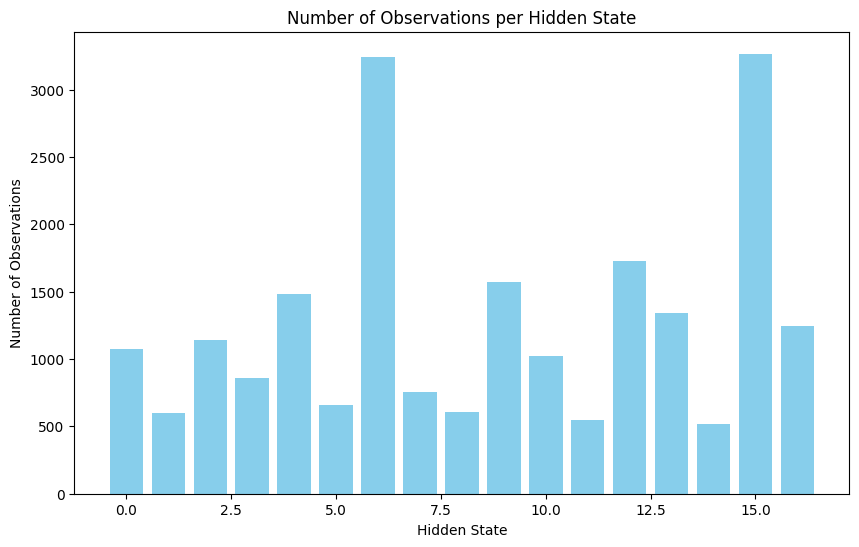

In [85]:
import matplotlib.pyplot as plt
from collections import Counter

# Predicted hidden states from your model
hidden_states = model.predict(processed_train_array.reshape(-1, 1), lengths)

# Count occurrences of each state
state_counts = Counter(hidden_states)

# Display the counts
print("Count of each hidden state:")
for state, count in state_counts.items():
    print(f"State {state}: {count}")
# Plot the counts of observations for each state
plt.figure(figsize=(10, 6))
plt.bar(range(model.n_components), [state_counts[i] for i in range(model.n_components)], color='skyblue')
plt.xlabel("Hidden State")
plt.ylabel("Number of Observations")
plt.title("Number of Observations per Hidden State")
plt.show()

In [86]:
"""
these are manually mapped
observation:state
91:13
100:9
58:9
68:9
109:9
165:15
208:13
90:9
166:16
209:13
184:14
12:1
185:14
5353:15
5354:16
220:10
119:10
150:13
8:1
43:0
"""

'\nthese are manually mapped\nobservation:state\n91:13\n100:9\n58:9\n68:9\n109:9\n165:15\n208:13\n90:9\n166:16\n209:13\n184:14\n12:1\n185:14\n5353:15\n5354:16\n220:10\n119:10\n150:13\n8:1\n43:0\n'

In [87]:
all_asset=np.concatenate(assetdisc_sequences)
print(len(all_asset))

146


Most Likely State Sequence: ['File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'Netapp operation', 'Execute process', 'Netapp operation', 'Execute process', 'Netapp operation', 'Execute process', 'Netapp operation', 'Execute process', 'Netapp operation', 'Execute process', 'Netapp operation', 'Execute process', 'Bash operation', 'Bash operation', 'Bash operation',

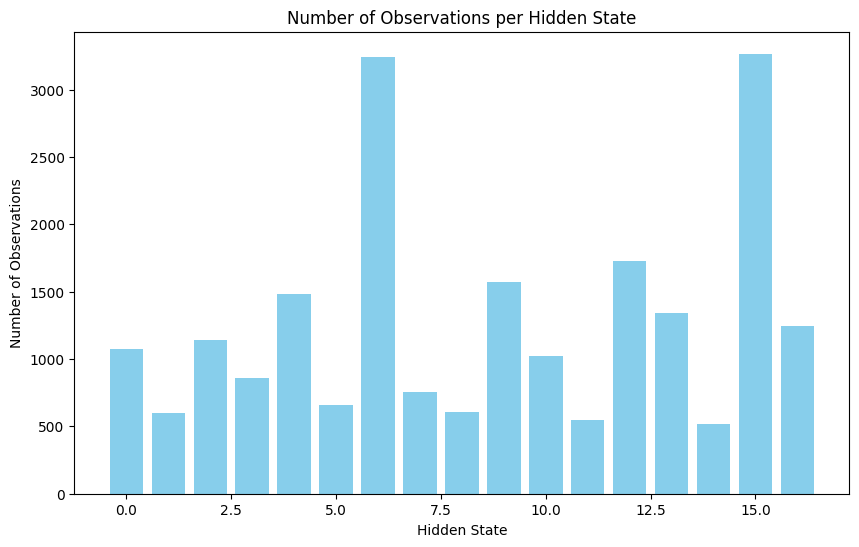

In [88]:
#convert obs to ids
asset=[[observation_to_id.get(item, "Unknown") for item in sublist] for sublist in assetdisc_sequences]
max_len = max(len(seq) for seq in asset)  # Find the maximum sequence length
padded_asset = [seq + [-1] * (max_len - len(seq)) for seq in asset]

# 2. Convert the padded sequences to a NumPy array
prep_asset = np.array(padded_asset)

# 3. Get lengths of the original sequences
asset_lengths = [len(seq) for seq in asset]

# Predicted hidden states from your model
#hidden_states = model.predict(prep_asset.reshape(-1, 1), asset_lengths)
# The change is here: We now concatenate all sequences into a single 1D array
concatenated_asset = np.concatenate(asset)
log_prob, predicted_states = model.decode(concatenated_asset.reshape(-1, 1), lengths=asset_lengths, algorithm="viterbi")
predicted_state_names = [states[state_id] for state_id in predicted_states]
print("Most Likely State Sequence:", predicted_state_names)

# Count occurrences of each state
state_counts = Counter(hidden_states)

# Display the counts
print("max length in asset discovery: ")
print(max_len)
print("Count of each hidden state:")
for state, count in state_counts.items():
    print(f"State {state}: {count}")
# Plot the counts of observations for each state
plt.figure(figsize=(10, 6))
plt.bar(range(model.n_components), [state_counts[i] for i in range(model.n_components)], color='skyblue')
plt.xlabel("Hidden State")
plt.ylabel("Number of Observations")
plt.title("Number of Observations per Hidden State")
plt.show()

In [89]:
gen_net = [[generalize_observation(obs) for obs in row] for row in networkdisc_sequences]
print(gen_net)

[['init → exec → check-new-relea', 'init → exec → apache2', 'check-new-relea → exec → check-new-relea', 'check-new-relea → connect → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'check-new-relea → ioctl → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'check-new-relea → recvfrom → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'check-new-relea → ioctl → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'check-new-relea → recvfrom → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'check-new-relea → close → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'check-new-relea → connect → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'check-new-relea → close → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'check-new-relea → connect → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'check-new-relea → sendto → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'check-new-relea → recvfrom → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'check-new-relea → close → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'init → exec → nmbd', 'nmbd → sendto → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'nmbd → sendto → IP_ADDRESS:PORT->IP_ADDRESS:PORT', 'init → ex

max length in network discovery: 
5515
Count of each hidden state:
State 9: 1569
State 7: 756
State 1: 596
State 8: 604
State 2: 1138
State 16: 1246
State 11: 546
State 3: 856
State 10: 1019
State 0: 1073
State 12: 1726
State 13: 1345
State 5: 655
State 14: 514
State 6: 3244
State 15: 3266
State 4: 1480


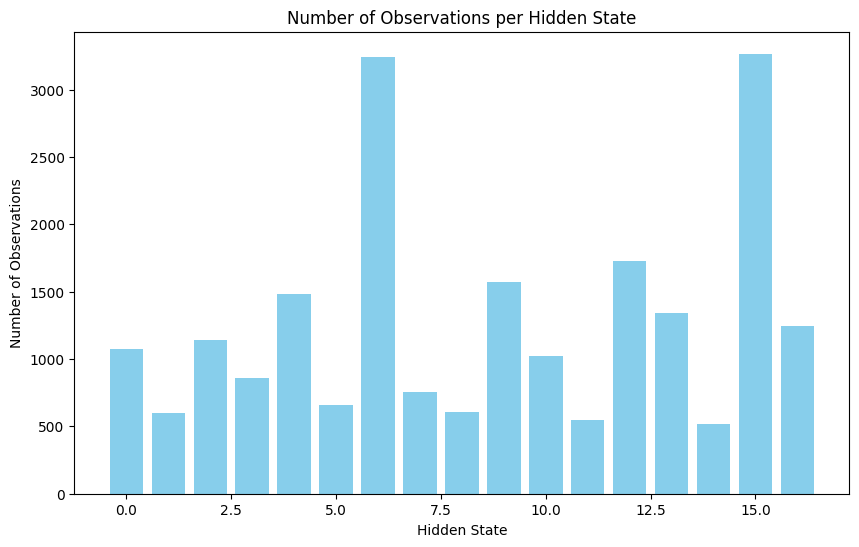

In [90]:
net=[[observation_to_id.get(item, "Unknown") for item in sublist] for sublist in gen_net]
max_len2 = max(len(seq) for seq in net)  # Find the maximum sequence length
padded_net = [seq + [-1] * (max_len2 - len(seq)) for seq in net]

# 2. Convert the padded sequences to a NumPy array
prep_net = np.array(padded_net)

# 3. Get lengths of the original sequences
net_lengths = [len(seq) for seq in net]

concatenated_net = np.concatenate(net)
log_prob2, predicted_states2 = model.decode(concatenated_net.reshape(-1, 1), lengths=net_lengths, algorithm="viterbi")
predicted_state_names2 = [states[state_id] for state_id in predicted_states2]


# Count occurrences of each state
state_counts2 = Counter(hidden_states)

# Display the counts
print("max length in network discovery: ")
print(max_len2)
print("Count of each hidden state:")
for state, count in state_counts.items():
    print(f"State {state}: {count}")
# Plot the counts of observations for each state
plt.figure(figsize=(10, 6))
plt.bar(range(model.n_components), [state_counts[i] for i in range(model.n_components)], color='skyblue')
plt.xlabel("Hidden State")
plt.ylabel("Number of Observations")
plt.title("Number of Observations per Hidden State")
plt.show()

Most Likely State Sequence: ['File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'Library state', 'Library state', 'Library state', 'Library state', 'Library state', 'Library state', 'Library state', 'Library state', 'Library state', 'Init server daemon', 'Init server daemon', 'Init server daemon', 'Init server daemon', 'Init server daemon', 'Init server daemon', 'Init server daemon', 'Init server daemon', 'Init server daemon', 'File operation', 'File operation', 'File operation', 'Library state', 'Library state', 'Library state', 'Library state', 'System information', 'Bash execute process', 'Process upload download', 'Netapp upload download', 'Process upload download', 'Netapp upload download', 'Process upload download', 'Netapp upload download', 'Process upload download', 'Bash execute process', 'System information', 'Bash execute process', 'Server upload', 'Server daemon operation', 'Generic

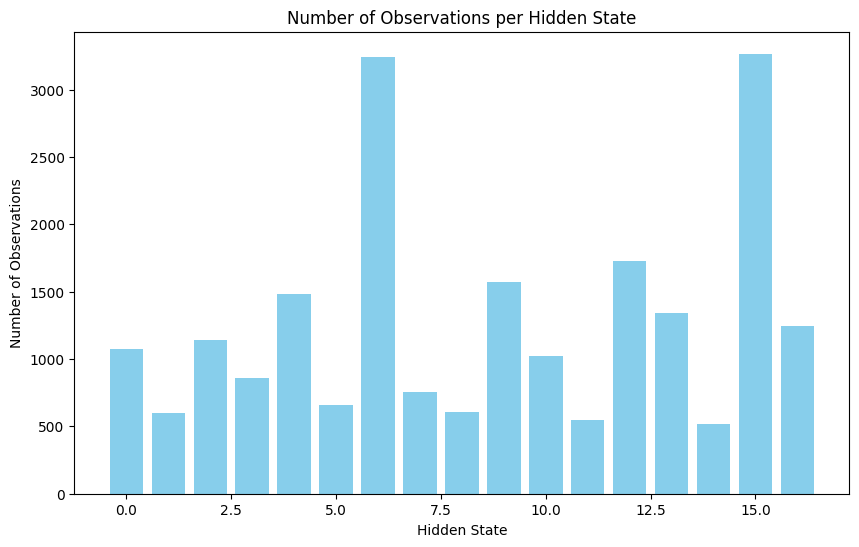

In [91]:
gen_exf = [[generalize_observation(obs) for obs in row] for row in dataexf_sequences]
exf=[[observation_to_id.get(item, "Unknown") for item in sublist] for sublist in gen_exf]
max_len3 = max(len(seq) for seq in exf)  # Find the maximum sequence length
padded_exf = [seq + [-1] * (max_len3 - len(seq)) for seq in exf]

# 2. Convert the padded sequences to a NumPy array
prep_exf = np.array(padded_exf)

# 3. Get lengths of the original sequences
exf_lengths = [len(seq) for seq in exf]

concatenated_exf = np.concatenate(exf)
log_prob3, predicted_states3 = model.decode(concatenated_exf.reshape(-1, 1), lengths=exf_lengths, algorithm="viterbi")
predicted_state_names3 = [states[state_id3] for state_id3 in predicted_states3]
print("Most Likely State Sequence:", predicted_state_names3)

# Count occurrences of each state
state_counts3 = Counter(hidden_states)

# Display the counts
print("max length in data exfiltration: ")
print(max_len3)
print("Count of each hidden state:")
for state, count in state_counts.items():
    print(f"State {state}: {count}")
# Plot the counts of observations for each state
plt.figure(figsize=(10, 6))
plt.bar(range(model.n_components), [state_counts[i] for i in range(model.n_components)], color='skyblue')
plt.xlabel("Hidden State")
plt.ylabel("Number of Observations")
plt.title("Number of Observations per Hidden State")
plt.show()

Most Likely State Sequence: ['File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'Server daemon operation', 'Server upload', 'Server daemon operation', 'Server upload', 'Server daemon operation', 'Server upload', 'Server daemon operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'Server daemon operation', 'Server upload', 'Server daemon operation', 'Server upload', 'Server daemon operation', 'Server upload', 'Server daemon operation', 'File operation', 'File operation', 'File operation', 'Server daemon operation', 'Server upload', 'Server daemon operation', 'Server upload', 'Server daemon operation', 'Server upload', 'Server daemon operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File op

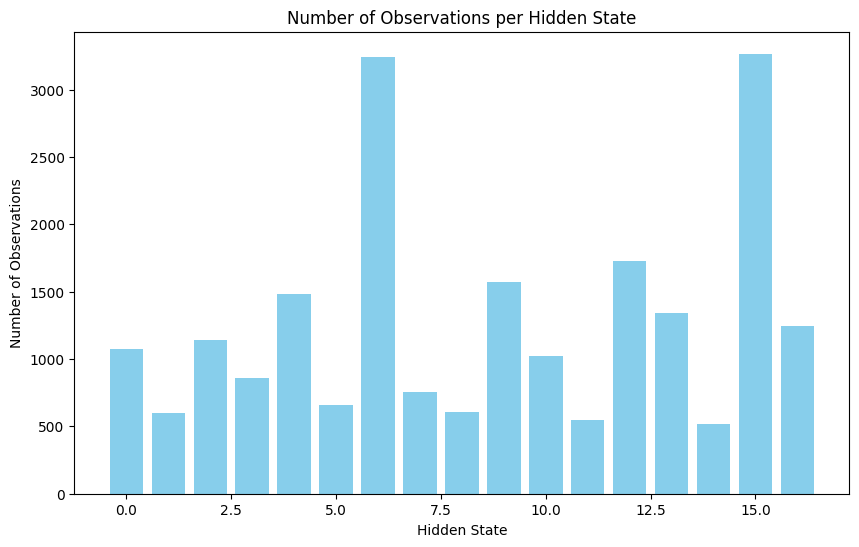

In [92]:
gen_pers = [[generalize_observation(obs) for obs in row] for row in persistence_sequences]
pers=[[observation_to_id.get(item, "Unknown") for item in sublist] for sublist in gen_pers]
max_len4 = max(len(seq) for seq in pers)  # Find the maximum sequence length
padded_pers = [seq + [-1] * (max_len4 - len(seq)) for seq in pers]

# 2. Convert the padded sequences to a NumPy array
prep_pers = np.array(padded_pers)

# 3. Get lengths of the original sequences
pers_lengths = [len(seq) for seq in pers]

concatenated_pers = np.concatenate(pers)
log_prob4, predicted_states4 = model.decode(concatenated_pers.reshape(-1, 1), lengths=pers_lengths, algorithm="viterbi")
predicted_state_names4 = [states[state_id4] for state_id4 in predicted_states4]
print("Most Likely State Sequence:", predicted_state_names4)

# Count occurrences of each state
state_counts4 = Counter(hidden_states)

# Display the counts
print("max length in persistence: ")
print(max_len4)
print("Count of each hidden state:")
for state, count in state_counts.items():
    print(f"State {state}: {count}")
# Plot the counts of observations for each state
plt.figure(figsize=(10, 6))
plt.bar(range(model.n_components), [state_counts[i] for i in range(model.n_components)], color='skyblue')
plt.xlabel("Hidden State")
plt.ylabel("Number of Observations")
plt.title("Number of Observations per Hidden State")
plt.show()

Most Likely State Sequence: ['File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation',

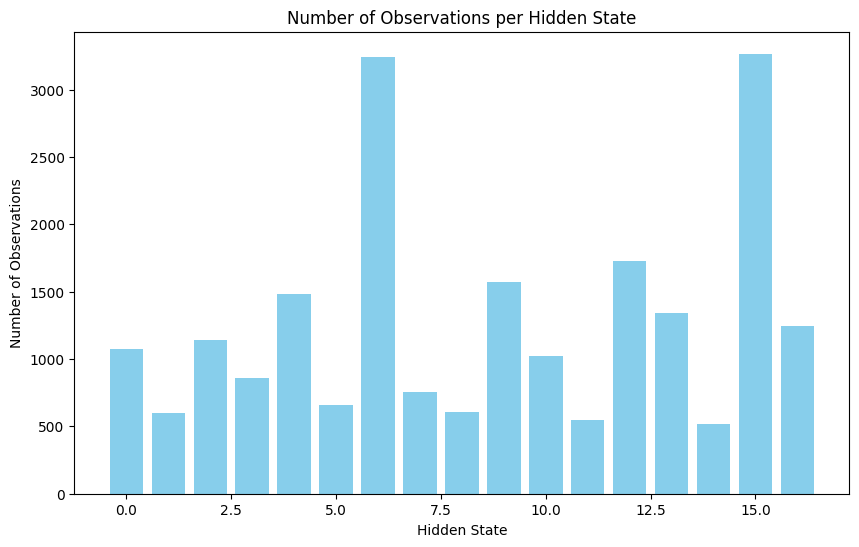

In [93]:
gen_priv = [[generalize_observation(obs) for obs in row] for row in privilegeesc_sequences]
priv=[[observation_to_id.get(item, "Unknown") for item in sublist] for sublist in gen_priv]
max_len5 = max(len(seq) for seq in priv)  # Find the maximum sequence length
padded_priv = [seq + [-1] * (max_len5 - len(seq)) for seq in priv]

# 2. Convert the padded sequences to a NumPy array
prep_priv = np.array(padded_priv)

# 3. Get lengths of the original sequences
priv_lengths = [len(seq) for seq in priv]

concatenated_priv = np.concatenate(priv)
log_prob5, predicted_states5 = model.decode(concatenated_priv.reshape(-1, 1), lengths=priv_lengths, algorithm="viterbi")
predicted_state_names5 = [states[state_id5] for state_id5 in predicted_states5]
print("Most Likely State Sequence:", predicted_state_names5)


# Count occurrences of each state
state_counts5 = Counter(hidden_states)

# Display the counts
print("max length in privilege escalation: ")
print(max_len5)
print("Count of each hidden state:")
for state, count in state_counts.items():
    print(f"State {state}: {count}")
# Plot the counts of observations for each state
plt.figure(figsize=(10, 6))
plt.bar(range(model.n_components), [state_counts[i] for i in range(model.n_components)], color='skyblue')
plt.xlabel("Hidden State")
plt.ylabel("Number of Observations")
plt.title("Number of Observations per Hidden State")
plt.show()

Most Likely State Sequence: ['File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'Bash operation', 'Bash operation', 'Bash operation', 'Bash operation', 'Bash operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'Library state', 'System information', 'Bash execute process', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'Bash operation', 'Bash operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File operation', 'File op

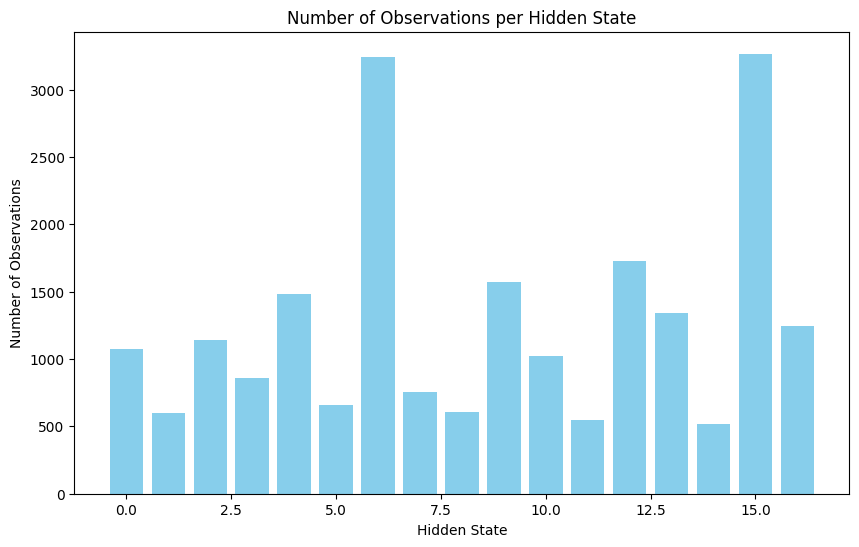

In [94]:
gen_recon = [[generalize_observation(obs) for obs in row] for row in reconnaissance_sequences]
recon=[[observation_to_id.get(item, "Unknown") for item in sublist] for sublist in gen_recon]
max_len6 = max(len(seq) for seq in recon)  # Find the maximum sequence length

padded_recon = [seq + [-1] * (max_len6 - len(seq)) for seq in recon]

# 2. Convert the padded sequences to a NumPy array
prep_recon = np.array(padded_recon)

# 3. Get lengths of the original sequences
recon_lengths = [len(seq) for seq in recon]

concatenated_recon = np.concatenate(recon)
log_prob6, predicted_states6 = model.decode(concatenated_recon.reshape(-1, 1), lengths=recon_lengths, algorithm="viterbi")
predicted_state_names6 = [states[state_id6] for state_id6 in predicted_states6]
print("Most Likely State Sequence:", predicted_state_names6)

# Count occurrences of each state
state_counts6 = Counter(hidden_states)

# Display the counts
print("max length in reconnaisance: ")
print(max_len6)
print("Count of each hidden state:")
for state, count in state_counts.items():
    print(f"State {state}: {count}")
# Plot the counts of observations for each state
plt.figure(figsize=(10, 6))
plt.bar(range(model.n_components), [state_counts[i] for i in range(model.n_components)], color='skyblue')
plt.xlabel("Hidden State")
plt.ylabel("Number of Observations")
plt.title("Number of Observations per Hidden State")
plt.show()

In [95]:
recon_states = []
start = 0

# Loop through the lengths and slice predicted_states6 accordingly
for length in recon_lengths:
    recon_states.append(predicted_states6[start:start+length].tolist())  # Convert slice to list
    start += length  # Move the start index forward by the current length

# Output the result
print(recon_states[:10])
print(len(recon_states))

[[9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9], [9, 9, 9, 9, 11, 10, 0, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]]
39


In [96]:
asset_states = []
start = 0

# Loop through the lengths and slice predicted_states6 accordingly
for length in asset_lengths:
    asset_states.append(predicted_states[start:start+length].tolist())  # Convert slice to list
    start += length  # Move the start index forward by the current length

# Output the result
print(asset_states[:10])
print(len(asset_states))

[[9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9], [9, 9, 9, 9, 9, 9, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 2, 16, 2], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 8, 8, 8, 8]]
16


In [97]:
net_states = []
start = 0
# Loop through the lengths and slice predicted_states6 accordingly
for length in net_lengths:
    net_states.append(predicted_states2[start:start+length].tolist())  # Convert slice to list
    start += length  # Move the start index forward by the current length

# Output the result
print(net_states[:10])
print(len(net_states))

[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 16, 2, 5, 14, 5, 2, 16, 5, 2, 16, 2, 16, 2, 16, 2, 16, 2, 16, 4, 4, 4, 4, 9, 9, 9, 4, 4, 4, 4, 4, 4, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 0, 10, 3, 3, 3, 10, 0, 12, 13, 12, 13, 0, 12, 13, 12, 13, 12, 13, 0, 12, 13, 12, 13, 12, 13, 0, 12, 13, 12, 13, 12, 13, 0, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 13, 12, 0, 10, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 10, 0, 12], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 16, 5, 2, 16, 2, 16, 2, 16, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [98]:
exf_states = []
start = 0

# Loop through the lengths and slice predicted_states6 accordingly
for length in exf_lengths:
    exf_states.append(predicted_states3[start:start+length].tolist())  # Convert slice to list
    start += length  # Move the start index forward by the current length

# Output the result
print(exf_states[:10])
print(len(exf_states))

[[9, 9, 9, 9, 9, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 3, 3, 3, 3, 3, 3, 3, 3, 3], [9, 9, 9, 11, 11, 11, 11, 10, 0, 12, 13, 12, 13, 12, 13, 12, 0, 10, 0, 16, 2, 5, 14, 5, 14, 10, 3, 3, 3, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 6, 15, 

In [99]:
pers_states = []
start = 0

# Loop through the lengths and slice predicted_states6 accordingly
for length in pers_lengths:
    pers_states.append(predicted_states4[start:start+length].tolist())  # Convert slice to list
    start += length  # Move the start index forward by the current length

print(pers_states[:10])
print(len(pers_states))

[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 16, 2, 16, 2, 16, 2], [9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 16, 2, 16, 2, 16, 2], [9, 9, 9, 2, 16, 2, 16, 2, 16, 2], [9, 9, 9, 9, 9, 9, 9, 9, 2, 16, 2, 16, 2, 16, 2], [9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 16, 2, 16, 2, 16, 2], [9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 16, 2, 16, 2, 16, 2], [9, 9, 9, 9, 9, 9, 9, 9, 2, 16, 2, 16, 2, 16, 2], [9, 9, 9, 9, 9, 9, 9, 9, 2, 16, 2, 16, 2, 16, 2], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 16, 2, 16, 2, 16, 2], [9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 16, 2, 16, 2, 16, 2]]
12


In [100]:
priv_states = []
start = 0

for length in priv_lengths:
    priv_states.append(predicted_states5[start:start+length].tolist())
    start += length

print(priv_states[:10])
print(len(priv_states))

[[9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 11, 11], [9, 9, 9, 9, 9, 9]]
14


In [108]:
x_data=[]
y_data=[]
for  i in range(len(asset_states)):
  x_data.append(asset_states[i])
  y_data.append(0)

for  i in range(len(net_states)):
  x_data.append(net_states[i])
  y_data.append(1)

for  i in range(len(exf_states)):
  x_data.append(exf_states[i])
  y_data.append(2)

for  i in range(len(pers_states)):
  x_data.append(pers_states[i])
  y_data.append(3)

for  i in range(len(priv_states)):
  x_data.append(priv_states[i])
  y_data.append(4)

for  i in range(len(recon_states)):
  x_data.append(recon_states[i])
  y_data.append(5)
y_dat=np.array(y_data)
print(len(x_data))
print(len(y_data))
print(x_data[:10])
print(y_data)
print(y_dat.shape)

114
114
[[9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9], [9, 9, 9, 9, 9, 9, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 2, 16, 2], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 8, 8, 8, 8]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
(114,)


In [112]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from sklearn.metrics import classification_report

sequence_length = 5515
X_data, y_dat = shuffle(X_data, y_dat, random_state=42)
# Pad sequences
X_data = pad_sequences(X_data, maxlen=sequence_length, padding='post')

# Check unique labels in y_data
print(f"Unique labels in y_data: {np.unique(y_dat)}")
print(f"Shape of y_data before reshaping: {y_dat.shape}")

y_dat1 = to_categorical(y_dat, num_classes=6)

# Step 2: Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_data, y_dat1, test_size=0.2, random_state=42)

# Step 3: Define the Model
model = Sequential()
model.add(Embedding(input_dim=5515, output_dim=100))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

# Step 4: Compile the Model
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Step 6: Predict on the Validation Set
y_pred = model.predict(X_val)

# Convert predictions and ground truth back to label format
y_pred_labels = np.argmax(y_pred, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Step 7: Print F1-Score using Classification Report
print(classification_report(y_val_labels, y_pred_labels, target_names=[str(i) for i in range(6)]))

Unique labels in y_data: [0 1 2 3 4 5]
Shape of y_data before reshaping: (114,)
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 543ms/step - accuracy: 0.1481 - loss: 1.7891 - val_accuracy: 0.0435 - val_loss: 1.7933
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step - accuracy: 0.2467 - loss: 1.7847 - val_accuracy: 0.2609 - val_loss: 1.7905
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step - accuracy: 0.2279 - loss: 1.7815 - val_accuracy: 0.2609 - val_loss: 1.7876
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - accuracy: 0.3555 - loss: 1.7756 - val_accuracy: 0.2609 - val_loss: 1.7846
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - accuracy: 0.3282 - loss: 1.7680 - val_accuracy: 0.2609 - val_loss: 1.7815
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step - accuracy: 0.3727 - loss: 1.7612 - val_accuracy: 0.2609 - val_loss: 1.7784
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step - accuracy: 0.3688 - loss: 1.7526 - val_accuracy: 0.2609 - val_loss: 1.7754
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [117]:
!pipreqs . --savepath requirements.txt --force

INFO: Not scanning for jupyter notebooks.
INFO: Successfully saved requirements file in requirements.txt


In [124]:
from google.colab import files
!pip freeze > requirements.txt
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>